## Метрика оценивания соревнования на Kaggle

Метрикой оценки является площадь под ROC-кривой(**ROC-AUC**).

## Загрузка библиотек

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# Предобработка данных

## Загрузка данных

In [36]:
train_df = pd.read_csv('data/preprocessed_data/preprocessed_train.csv')
test_df = pd.read_csv('data/preprocessed_data/preprocessed_test.csv')
submission = pd.read_csv('data/preprocessed_data/submission.csv')

In [4]:
train_df.head()

,CreditScore,Geography_Germany,Geography_Spain,Gender_Male,Age,AgeGroup_1,AgeGroup_2,AgeGroup_3,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,IsActiveByCrCard,TenureAgeRatio,Exited
0,668,False,False,True,33.0,True,False,False,3,0.00,2,1.0,0.0,181449.97,0.0,0.090909,0
1,627,False,False,True,33.0,True,False,False,1,0.00,2,1.0,1.0,49503.50,1.0,0.030303,0
2,678,False,False,True,40.0,True,False,False,10,0.00,2,1.0,0.0,184866.69,0.0,0.250000,0
3,581,False,False,True,34.0,True,False,False,2,148882.54,1,1.0,1.0,84560.88,1.0,0.058824,0
4,716,False,True,True,33.0,True,False,False,5,0.00,2,1.0,1.0,15068.83,1.0,0.151515,0


## Функции

### Функция для кросс-валидации

In [14]:
def find_best_parameters(X_train, y_train, model):

    if "XGB" in str(model.__class__):
        parameters = {'iterations' : range(200, 500, 100),
                      'learning_rate': [0.01, 0.05, 0.1],
                      'max_depth': range(3, 9, 3),
                      'reg_lambda': range(1, 7, 2)}

    elif "LGBM" in str(model.__class__):
        parameters = {'n_estimators' : range(200, 500, 100),
                      'learning_rate': [0.01, 0.05, 0.1],
                      'max_depth': range(3, 9, 3),
                      'reg_lambda': range(1, 7, 2)}
    else:
        parameters = {'iterations' : range(200, 500, 100),
                      'learning_rate': [0.01, 0.05, 0.1],
                      'max_depth': range(3, 9, 3),
                      'l2_leaf_reg': range(1, 7, 2)}

    kf = StratifiedKFold(n_splits=10,
                         shuffle=True,
                         random_state=42)

    grid_search_cv = GridSearchCV(estimator=model,
                                  param_grid=parameters,
                                  cv=kf,
                                  scoring='roc_auc',
                                  n_jobs=2,
                                  verbose=0)

    grid_search_cv.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    
    return grid_search_cv.best_estimator_, grid_search_cv.best_params_

### Функция для вывода метрик

In [46]:
def metrics_summary(y_pred, y_pred_proba, model):
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'F1: {f1_score(y_test, y_pred)}')
    print(f'\033[4mROC-AUC\033[0m: {roc_auc_score(y_test, y_pred_proba)}')

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, labels=model.classes_),
                                  display_labels=model.classes_)
    disp.plot()
    plt.show()

## Разделение данных на тренировочную, валидационную и тестовую выборки

In [37]:
X = train_df.drop(['Exited'], axis = 1)
y = train_df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Построение моделей

## XGBoost

### Подбор параметров

In [ ]:
xgb_clf = XGBClassifier(verbosity=0)
start_time = time.time()
best_xgb_clf, best_xgb_params = find_best_parameters(X_train, y_train, xgb_clf)
end_time = time.time()

In [43]:
print(f'Лучшие параметры: {best_xgb_params}')
print(f'Общее время, затраченное на кросс-валидацию (в минутах): {(end_time - start_time)/60}')

Лучшие параметры: {'iterations': 200, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 3}
Общее время, затраченное на кросс-валидацию (в минутах): 8.638734511534373


### Оценка важности признаков

C:\Users\MrDin\AppData\Local\Temp\ipykernel_5240\1512889107.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(feature_importance,


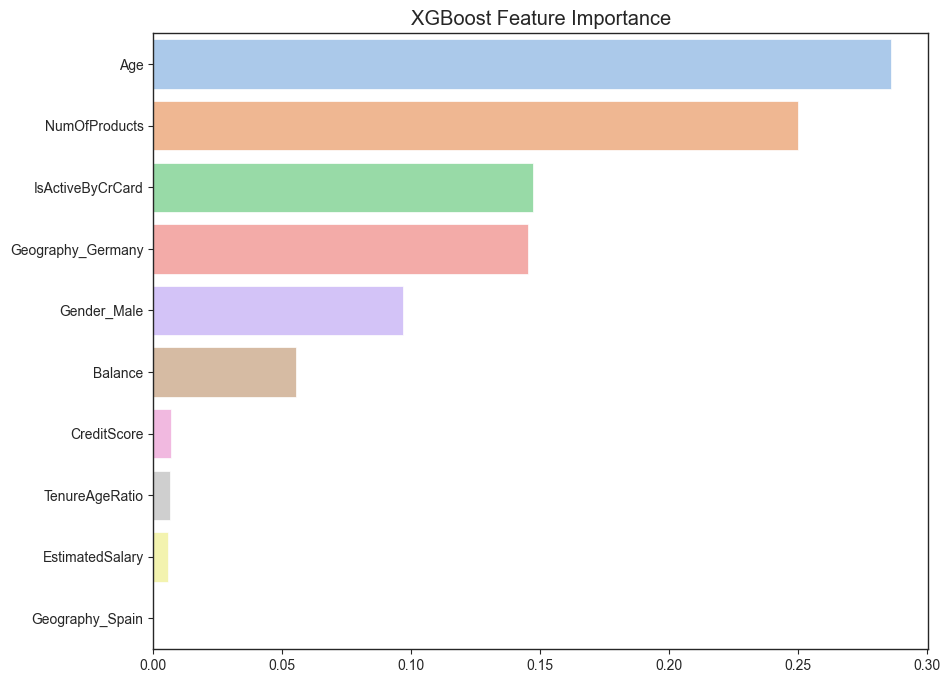

In [40]:
importances = best_xgb_clf.feature_importances_

feature_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
sns.set_style("ticks")
plt.figure(figsize=(10, 8))
sns.barplot(feature_importance,
            orient="h",
            palette='pastel')
plt.title('XGBoost Feature Importance')
plt.style.use('ggplot')
plt.show()

### Тестирование модели и результаты по основным метрикам

Accuracy: 0.8608677197344087
Precision: 0.7466291004226202
Recall: 0.5269886363636364
F1: 0.6178699308851695
ROC-AUC: 0.8848056945427565


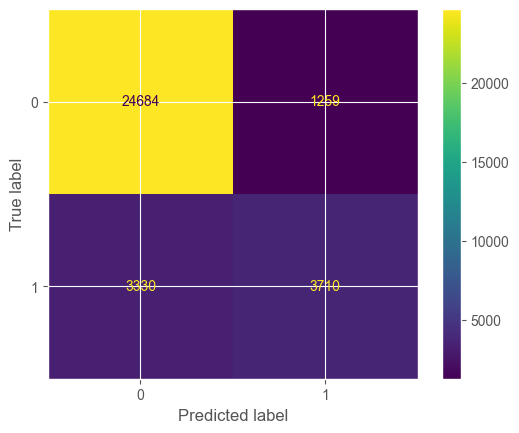

<Figure size 480x320 with 0 Axes>

In [47]:
y_pred = best_xgb_clf.predict(X_test)
y_pred_proba = best_xgb_clf.predict_proba(X_test)[:, 1]
metrics_summary(y_pred, y_pred_proba, best_xgb_clf)

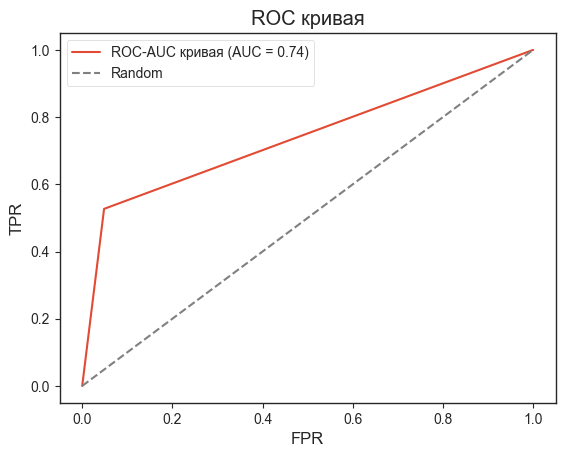

In [42]:
sns.set_style("ticks")
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f'ROC-AUC кривая (AUC = {roc_auc_score(y_test, y_pred):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC кривая')
plt.legend()
plt.style.use('ggplot')
plt.show()

### Kaggle Score

In [22]:
submission['Exited'] = best_xgb_clf.predict(test_df)
submission.to_csv("data/submissions/xgb_submission.csv", index=False)

![xgb_submission](data/img/xgb_submission.png)

## LightGBM

### Подбор параметров

In [48]:
lgbm_clf = LGBMClassifier(class_weight='balanced', verbose=-1)
start_time = time.time()
best_lgbm_clf, best_lgbm_params = find_best_parameters(X_train, y_train, lgbm_clf)
end_time = time.time()

In [53]:
print(f'Лучшие параметры: {best_lgbm_params}')
print(f'Общее время, затраченное на кросс-валидацию (в минутах): {(end_time - start_time)/60}')

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 5}
Общее время, затраченное на кросс-валидацию (в минутах): 8.364623324076335


### Оценка важности признаков

C:\Users\MrDin\AppData\Local\Temp\ipykernel_5240\495267549.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(feature_importance,


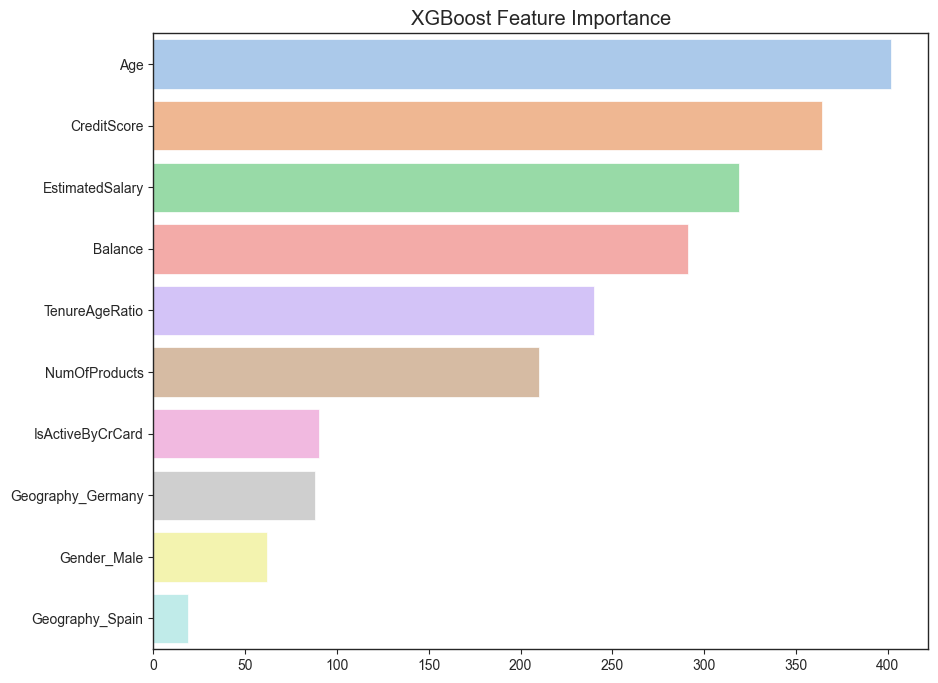

In [50]:
importances = best_lgbm_clf.feature_importances_

feature_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
sns.set_style("ticks")
plt.figure(figsize=(10, 8))
sns.barplot(feature_importance,
            orient="h",
            palette='pastel')
plt.title('XGBoost Feature Importance')
plt.style.use('ggplot')
plt.show()

### Тестирование модели и результаты по основным метрикам

Accuracy: 0.8047782190825576
Precision: 0.5284591343877261
Recall: 0.7926136363636364
F1: 0.6341269390306268
ROC-AUC: 0.8851950041042775


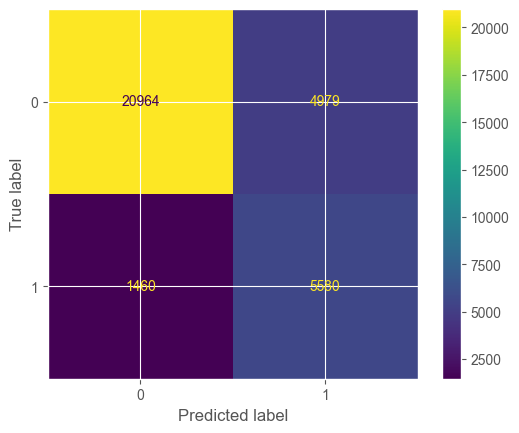

<Figure size 480x320 with 0 Axes>

In [51]:
y_pred = best_lgbm_clf.predict(X_test)
y_pred_proba = best_lgbm_clf.predict_proba(X_test)[:, 1]
metrics_summary(y_pred, y_pred_proba, best_lgbm_clf)

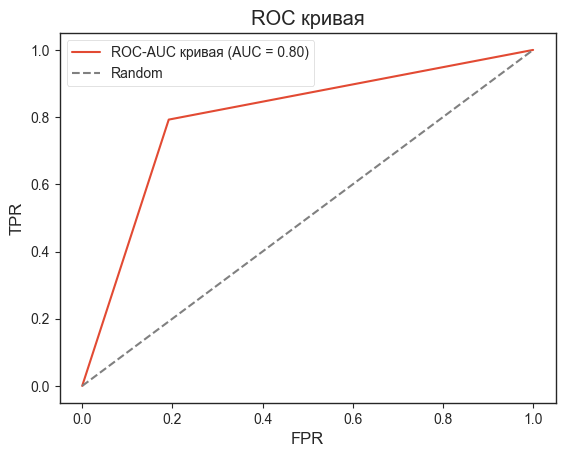

In [52]:
sns.set_style("ticks")
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f'ROC-AUC кривая (AUC = {roc_auc_score(y_test, y_pred):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC кривая')
plt.legend()
plt.style.use('ggplot')
plt.show()

### Kaggle Score

In [30]:
submission['Exited'] = best_lgbm_clf.predict(test_df)
submission.to_csv("data/submissions/lgbm_submission.csv", index=False)

![lgbm_submission](data/img/lgbm_submission.png)

## CatBoost

### Подбор параметров

In [31]:
catboost_clf = CatBoostClassifier(auto_class_weights='Balanced', loss_function='Logloss', verbose=False)
start_time = time.time()
best_catboost_clf, best_catboost_params = find_best_parameters(X_train, y_train, catboost_clf)
end_time = time.time()

Лучшие параметры: {'iterations': 400, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'max_depth': 3}
Общее время, затраченное на кросс-валидацию (в минутах): 24.94541160662969


In [ ]:
print(f'Лучшие параметры: {best_catboost_params}')
print(f'Общее время, затраченное на кросс-валидацию (в минутах): {(end_time - start_time)/60}')

### Оценка важности признаков

C:\Users\MrDin\AppData\Local\Temp\ipykernel_5240\1852608812.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(feature_importance,


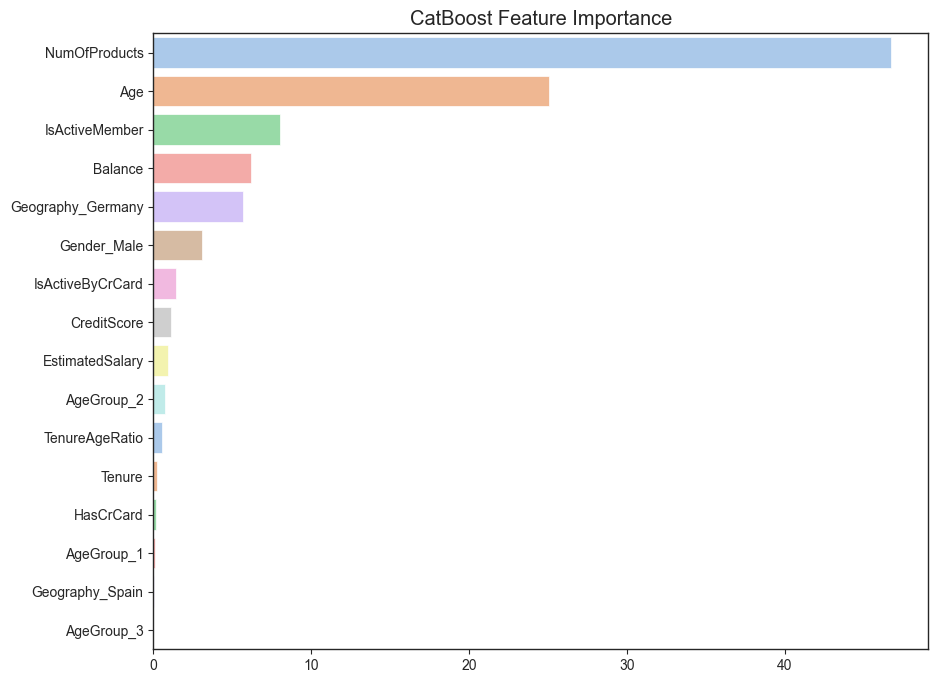

In [32]:
feature_names = best_catboost_clf.feature_names_
importances = best_catboost_clf.get_feature_importance(type='PredictionValuesChange')

feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
sns.set_style("ticks")
plt.figure(figsize=(10, 8))
sns.barplot(feature_importance,
            orient="h",
            palette='pastel')
plt.title('CatBoost Feature Importance')
plt.style.use('ggplot')
plt.show()

### Тестирование модели и результаты по основным метрикам

Accuracy: 0.8109935421277628
Precision: 0.5388546085615118
Recall: 0.7938920454545455
F1: 0.6419710544452102
ROC-AUC: 0.8895103322011894


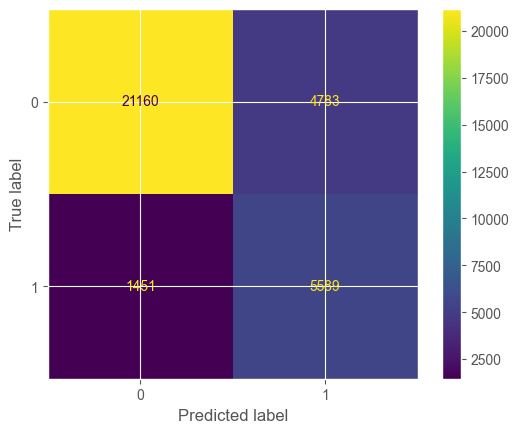

In [33]:
y_pred = best_catboost_clf.predict(X_test)
y_pred_proba = best_catboost_clf.predict_proba(X_test)[:, 1]
metrics_summary(y_pred, y_pred_proba, best_catboost_clf)

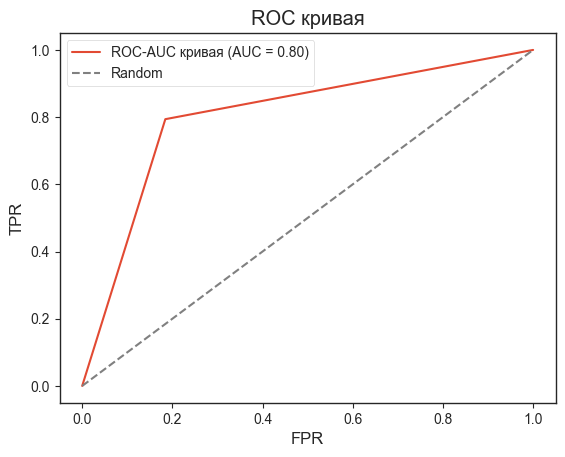

In [34]:
sns.set_style("ticks")
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f'ROC-AUC кривая (AUC = {roc_auc_score(y_test, y_pred):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC кривая')
plt.legend()
plt.style.use('ggplot')
plt.show()

### Kaggle Score

In [35]:
submission['Exited'] = best_catboost_clf.predict(test_df)
submission.to_csv("data/submissions/catboost_submission.csv", index=False)

![catboost_submission](data/img/catboost_submission.png)

## Результаты

- При построении моделей были использованы предобработанные данные. В предобработку входили кодировка категориальных признаков и генерация новых признаков на основе имеющихся;
- Были построены 3 модели - XGBoost, LightGBM, Catboost;
- Для подбора параметров моделей использовалась кросс-валидация;
- CatBoost модель показала лучший результат по целевой метрике, XGBoost модель - худший.

### Итоговые показатели метрики ROC-AUC для каждой модели на тестовой выборке

- **_XGBoost_** - 0.75597
- **_LightGBM_** - 0.80480
- **_CatBoost_** - 0.80544